In [210]:
!pip install --upgrade category_encoders
!pip install lightgbm
!pip install xgboost
!pip install graphviz
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import category_encoders as ce
import xgboost as xgb
import datetime
from sklearn.model_selection import GridSearchCV
import pytz

In [211]:
import sys

In [212]:
class Tee(object):
    def __init__(self, *files):
        self.files = files
    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush() # If you want the output to be visible immediately
    def flush(self) :
        for f in self.files:
            f.flush()

Levanto la data de los DFS

In [213]:
train_labels = pd.read_csv('./train_labels.csv')
train_values = pd.read_csv('./train_values.csv')
df_test = pd.read_csv('./test_values.csv')
train_values_with_prob = pd.read_csv('./train_values_with_prob.csv')
train_values_with_prob = train_values_with_prob.iloc[:,1:]

In [214]:
fea = pd.merge(train_values, train_labels, on='building_id')

In [215]:
fea_encoding = pd.get_dummies(fea, columns =["damage_grade"])

In [216]:
fea_encoding

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade_1,damage_grade_2,damage_grade_3
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,1
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,1,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,1
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,1,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0,0,0,0,0,0,0,1,0
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0,0,0,0,0,0,0,0,1
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0,0,0,0,0,0,0,0,1
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0,0,0,0,0,0,0,1,0


In [218]:
encoder = ce.TargetEncoder(cols="geo_level_1_id")
fea_encoding['prob1_geo1'] = encoder.fit_transform(fea_encoding['geo_level_1_id'], fea_encoding['damage_grade_1'])

C:\Users\Pato\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [219]:
fea_encoding["prob1_geo1"]

0         0.086461
1         0.034277
2         0.021627
3         0.129718
4         0.046959
            ...   
260596    0.083215
260597    0.013066
260598    0.013066
260599    0.354986
260600    0.021627
Name: prob1_geo1, Length: 260601, dtype: float64

In [223]:
list1 = fea_encoding["prob1_geo1"] - train_values_with_prob["prob1_geo1"]

In [225]:
list1.max()

8.326672684688674e-17

In [167]:

if (len(train_values_with_prob) == 0):
  fea = pd.merge(train_values, train_labels, on='building_id')
  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_1_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_1_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo1'] = list1
  train_values['prob2_geo1'] = list2
  train_values['prob3_geo1'] = list3

  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_2_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_2_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo2'] = list1
  train_values['prob2_geo2'] = list2
  train_values['prob3_geo2'] = list3


  damage1 = {}
  damage2 = {}
  damage3 = {}
  for i,j in (train_values['geo_level_3_id'].value_counts()).iteritems():
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])
    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j
  list1 = []
  list2 = []
  list3 = []
  for i in train_values['geo_level_3_id']:
      list1.append(damage1.get(i))
      list2.append(damage2.get(i))
      list3.append(damage3.get(i))
  train_values['prob1_geo3'] = list1
  train_values['prob2_geo3'] = list2
  train_values['prob3_geo3'] = list3
  train_values.to_csv('/content/drive/MyDrive/datasets_tp2/train_values_with_prob.csv')
  

train_values = train_values_with_prob


In [168]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0,0,0,0,0,0,0,0,0


In [169]:
#df_test[(df_test["prob1_geo" + str(3)].isna())]
#df_test2 = df_test.merge(df_train_without_dp,on="geo_level_" + str(3) + "_id",how="left")

In [170]:
#df_test2

In [171]:
#df_test2["prob1_geo" + str(3)].mean()

In [172]:
#df_test2["prob1_geo" + str(3)] = df_test2["prob1_geo" + str(3)].fillna(df_test2["prob1_geo" + str(3)].mean()) 

In [173]:
#df_test2["prob1_geo" + str(3)].fillna(df_test2["prob1_geo" + str(3)].mean()).isnull().sum().sum()

In [174]:
#df_test2.isnull().sum().sum()

In [175]:
for k in range(1, 4):
  df_train_without_dp = train_values[["prob1_geo" + str(k),"prob2_geo"+ str(k),"prob3_geo"+ str(k),"geo_level_" + str(k) + "_id"]].drop_duplicates()
  df_test = df_test.merge(df_train_without_dp,on="geo_level_" + str(k) + "_id",how="left")
  df_test["prob1_geo" + str(k)] = df_test["prob1_geo" + str(k)].fillna(df_test["prob1_geo" + str(k)].mean())  
  df_test["prob2_geo" + str(k)] = df_test["prob2_geo" + str(k)].fillna(df_test["prob2_geo" + str(k)].mean()) 
  df_test["prob3_geo" + str(k)] = df_test["prob3_geo" + str(k)].fillna(df_test["prob3_geo" + str(k)].mean()) 

df_test
# df_test= df_test.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])
# train_values= train_values.drop(columns=["geo_level_1_id","geo_level_2_id","geo_level_3_id"])

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,...,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


In [176]:
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [177]:
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0.086461,0.665354,0.248185,0.003704,0.251852,0.744444,0.000000,0.162162,0.837838
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0.034277,0.446174,0.519549,0.010050,0.492462,0.497487,0.062500,0.812500,0.125000
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0.021627,0.393378,0.584996,0.082386,0.316477,0.601136,0.029412,0.360294,0.610294
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0.129718,0.739603,0.130678,0.019512,0.853659,0.126829,0.032258,0.838710,0.129032
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0.046959,0.568370,0.384672,0.029865,0.591522,0.378613,0.008197,0.614754,0.377049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,...,0,0.083215,0.779516,0.137269,0.172414,0.724138,0.103448,0.000000,0.928571,0.071429
260597,669485,17,715,2060,2,0,6,5,t,r,...,0,0.013066,0.179388,0.807546,0.003831,0.061303,0.934866,0.000000,0.020408,0.979592
260598,602512,17,51,8163,3,55,6,7,t,r,...,0,0.013066,0.179388,0.807546,0.024024,0.057057,0.918919,0.045455,0.090909,0.863636
260599,151409,26,39,1851,2,10,14,6,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.220339,0.766949,0.012712


In [178]:
df_test

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_other,prob1_geo1,prob2_geo1,prob3_geo1,prob1_geo2,prob2_geo2,prob3_geo2,prob1_geo3,prob2_geo3,prob3_geo3
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0.013066,0.179388,0.807546,0.007194,0.280576,0.712230,0.052632,0.263158,0.684211
1,99355,6,141,11987,2,25,13,5,t,r,...,0,0.086461,0.665354,0.248185,0.000000,0.819149,0.180851,0.000000,1.000000,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0.129718,0.739603,0.130678,0.000000,0.825000,0.175000,0.000000,0.000000,1.000000
3,745817,26,39,633,1,0,19,3,t,r,...,0,0.354986,0.559142,0.085872,0.507429,0.452947,0.039624,0.571429,0.419355,0.009217
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0.013066,0.179388,0.807546,0.005181,0.300518,0.694301,0.000000,0.176471,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,...,0,0.035763,0.766337,0.197900,0.056604,0.764151,0.179245,0.194444,0.750000,0.055556
86864,663567,10,1407,11907,3,25,6,7,n,r,...,0,0.054848,0.548349,0.396802,0.060519,0.541787,0.397695,0.000000,0.277778,0.722222
86865,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0.129718,0.739603,0.130678,0.083744,0.812808,0.103448,0.090909,0.909091,0.000000
86866,442785,6,1041,912,2,5,9,5,t,r,...,0,0.086461,0.665354,0.248185,0.065421,0.573209,0.361371,0.090909,0.681818,0.227273


Feature Engineering

Usamos BinaryEncoder de los categoricos

In [179]:

df_train_encoding = pd.get_dummies(train_values, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])
df_test_encoding = pd.get_dummies(df_test, columns =['land_surface_condition', 'foundation_type', \
                            'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status'])
#encoder= ce.BinaryEncoder(cols= ['land_surface_condition', 'foundation_type', \
                              #   'roof_type', 'ground_floor_type', 'other_floor_type',\
                               #  'position', 'plan_configuration', 'legal_ownership_status'], return_df = True)

#df_train_encoding = encoder.fit_transform(train_values)
#df_test_encoding = encoder.fit_transform(df_test)

#df_train_encoding=df_train_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])
#df_test_encoding=df_test_encoding.drop(columns=["land_surface_condition_0","foundation_type_0","roof_type_0","ground_floor_type_0","plan_configuration_0"])


In [180]:
 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_use_police"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_use_police"])

 df_train_encoding=df_train_encoding.drop(columns=["has_secondary_use_health_post"])
 df_test_encoding=df_test_encoding.drop(columns=["has_secondary_use_health_post"])

 df_train_encoding=df_train_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])
 df_test_encoding=df_test_encoding.drop(columns=["geo_level_2_id","geo_level_3_id"])
# df_train_encoding=df_train_encoding.drop(columns=["legal_ownership_status_0","legal_ownership_status_1","legal_ownership_status_2"])
# df_test_encoding=df_test_encoding.drop(columns=["legal_ownership_status_0","legal_ownership_status_1","legal_ownership_status_2"])

In [181]:
df_train_encoding.columns

Index(['building_id', 'geo_level_1_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_gov_office',
       'has_secondary_use_other', 'prob1_geo1', 'prob2_geo1', 'prob3_geo1',
       'prob1_geo2', 'prob2_geo2', 'prob3_geo2', 'prob1_geo3', 'prob2_geo3',
       'prob3_geo3', 

In [182]:
df_train_encoding

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,2,30,6,5,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,28830,8,2,10,8,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,94947,21,2,10,5,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,590882,22,2,10,6,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,201944,11,3,30,8,9,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1,55,6,3,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
260597,669485,17,2,0,6,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
260598,602512,17,3,55,6,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
260599,151409,26,2,10,14,6,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [183]:
df_test_encoding

,building_id,geo_level_1_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,300051,17,3,20,7,6,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,99355,6,2,25,13,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,890251,22,2,5,4,5,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,745817,26,1,0,19,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,421793,17,3,15,8,7,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,3,70,20,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
86864,663567,10,3,25,6,7,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0
86865,1049160,22,1,50,3,3,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
86866,442785,6,2,5,9,5,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [184]:
df_test_encoding.columns

Index(['building_id', 'geo_level_1_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_gov_office',
       'has_secondary_use_other', 'prob1_geo1', 'prob2_geo1', 'prob3_geo1',
       'prob1_geo2', 'prob2_geo2', 'prob3_geo2', 'prob1_geo3', 'prob2_geo3',
       'prob3_geo3', 

In [185]:

#temp = df_test_encoding[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']]

#df_test_encoding[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']] =(temp-temp.mean())/temp.std()

#temp = df_train_encoding[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']]
#df_train_encoding[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']] =(temp-temp.mean())/temp.std()





Armamos y entrenamos el modelo XGBOOST

In [186]:
df_test_encoding = df_test_encoding.iloc[:,1:]
X = df_train_encoding.iloc[:, 1:]
y = train_labels.iloc[:, 1:]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [188]:
params_lgb = {
        "objective" : "multiclass",
        "num_class":3,
        "metric" : "multi_logloss",
        "boosting": 'gbdt',
        "max_depth" :9,
        "num_leaves" : 40,
        "learning_rate" : 0.05,
        "feature_fraction" : 0.5,
        "min_sum_hessian_in_leaf" : 0.1,
        "max_bin":8200,
        "verbosity" : 1,
        "num_threads":6,
        "seed": 1800
    }

In [189]:
#https://neptune.ai/blog/lightgbm-parameters-guide
lgb_cl = lgb.LGBMClassifier(**params_lgb,num_boost_round=1000)

In [190]:
xgb_cl = xgb.XGBClassifier(min_child_weight= 5, learning_rate= 0.1, gamma= 0.05, subsample= 0.8,colsample_bytree= 0.3, colsample_bynode= 0.8,
 colsample_bylevel= 0.8, max_depth = 20, n_estimators = 150)

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier


#clf2 = RandomForestClassifier(n_estimators=50, random_state=1)



eclf = VotingClassifier(
     estimators=[('xgb', xgb_cl), ('lgb', lgb_cl)],
     voting='hard')


eclf.fit(X_train, y_train)

C:\Users\Pato\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Pato\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Pato\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] num_threads is

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=0.8,
                                            colsample_bynode=0.8,
                                            colsample_bytree=0.3, gamma=0.05,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=20,
                                            min_child_weight=5, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=150, n_jobs=...
                                            scale_pos_weight=None,
                                            subsample=0.8, tree_method=None,
               

<BarContainer object of 73 artists>

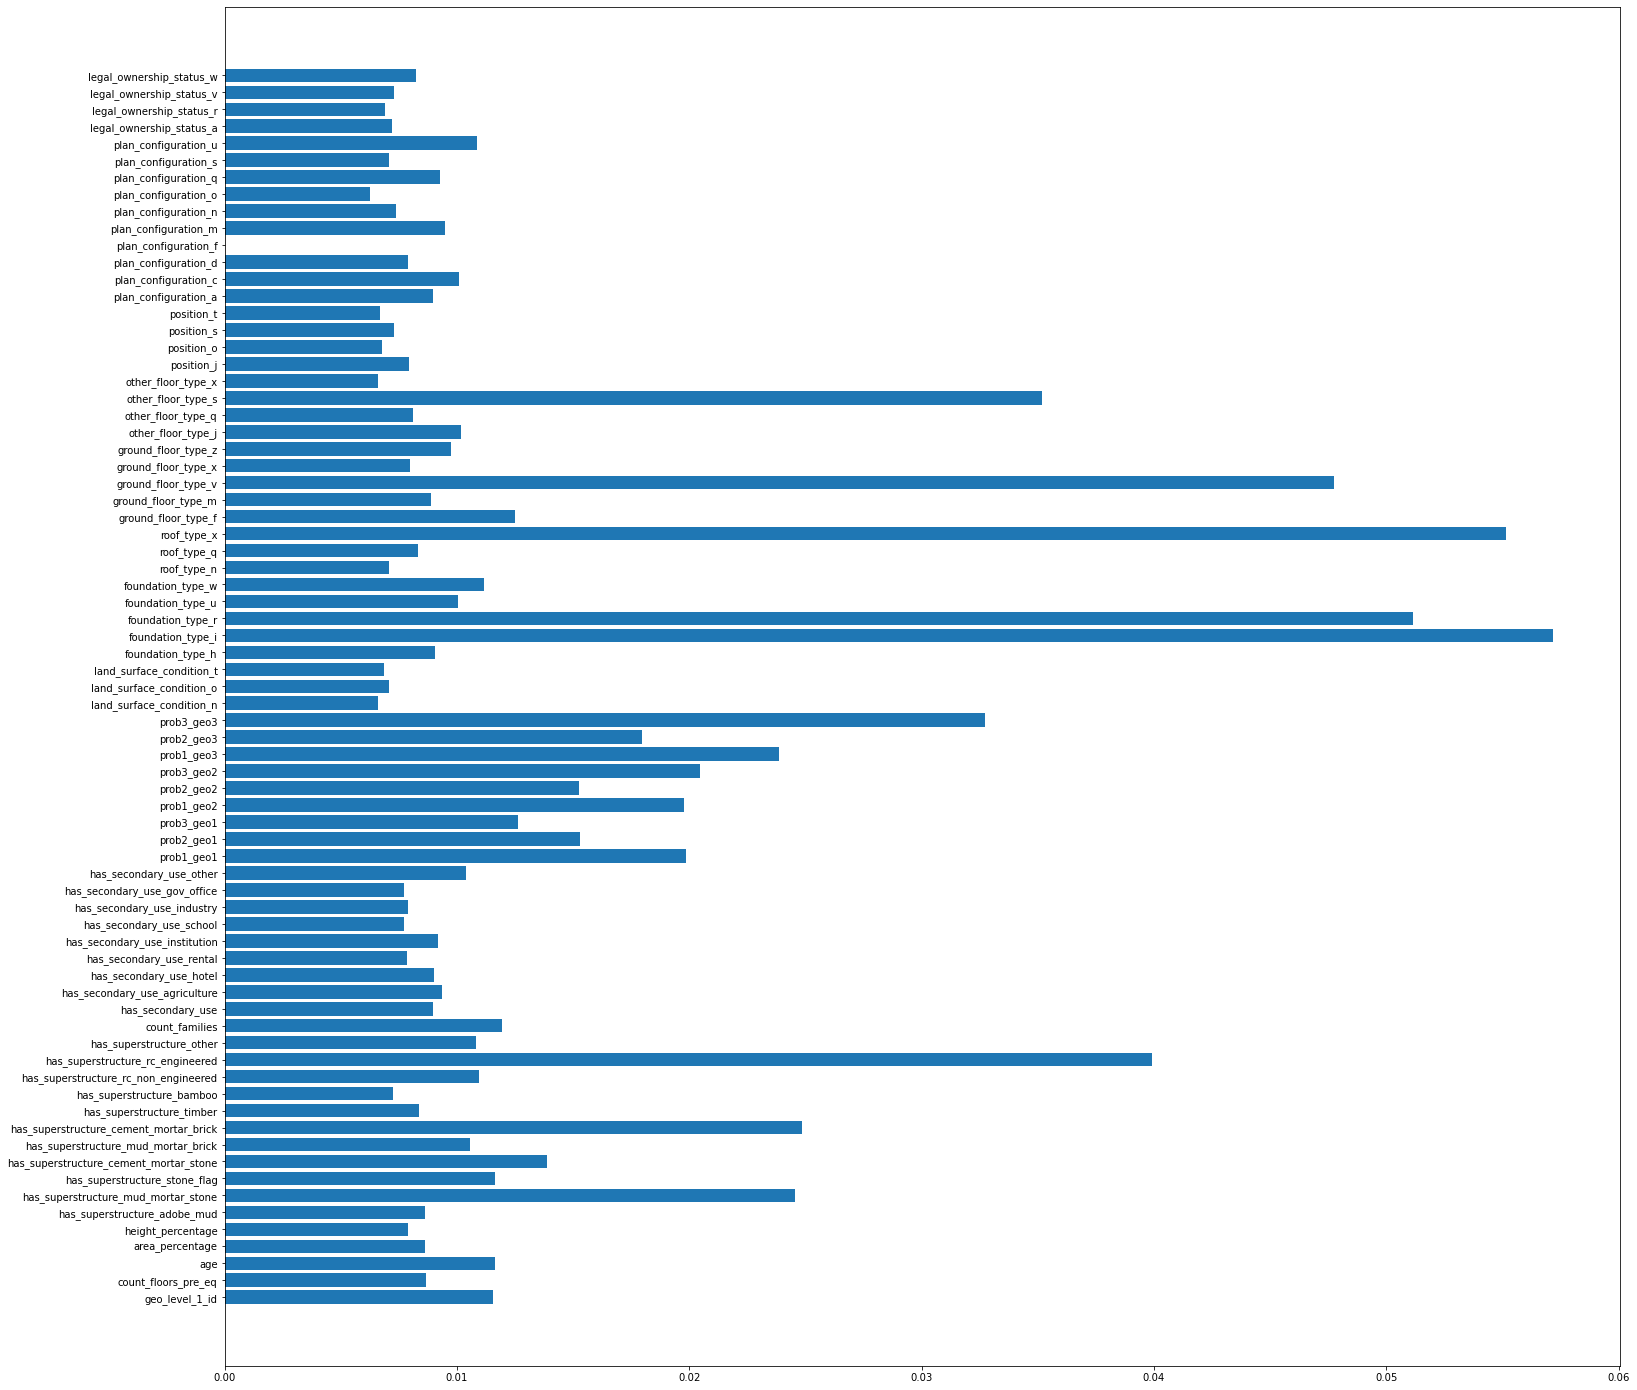

In [192]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, eclf.estimators_[0].feature_importances_)

<BarContainer object of 73 artists>

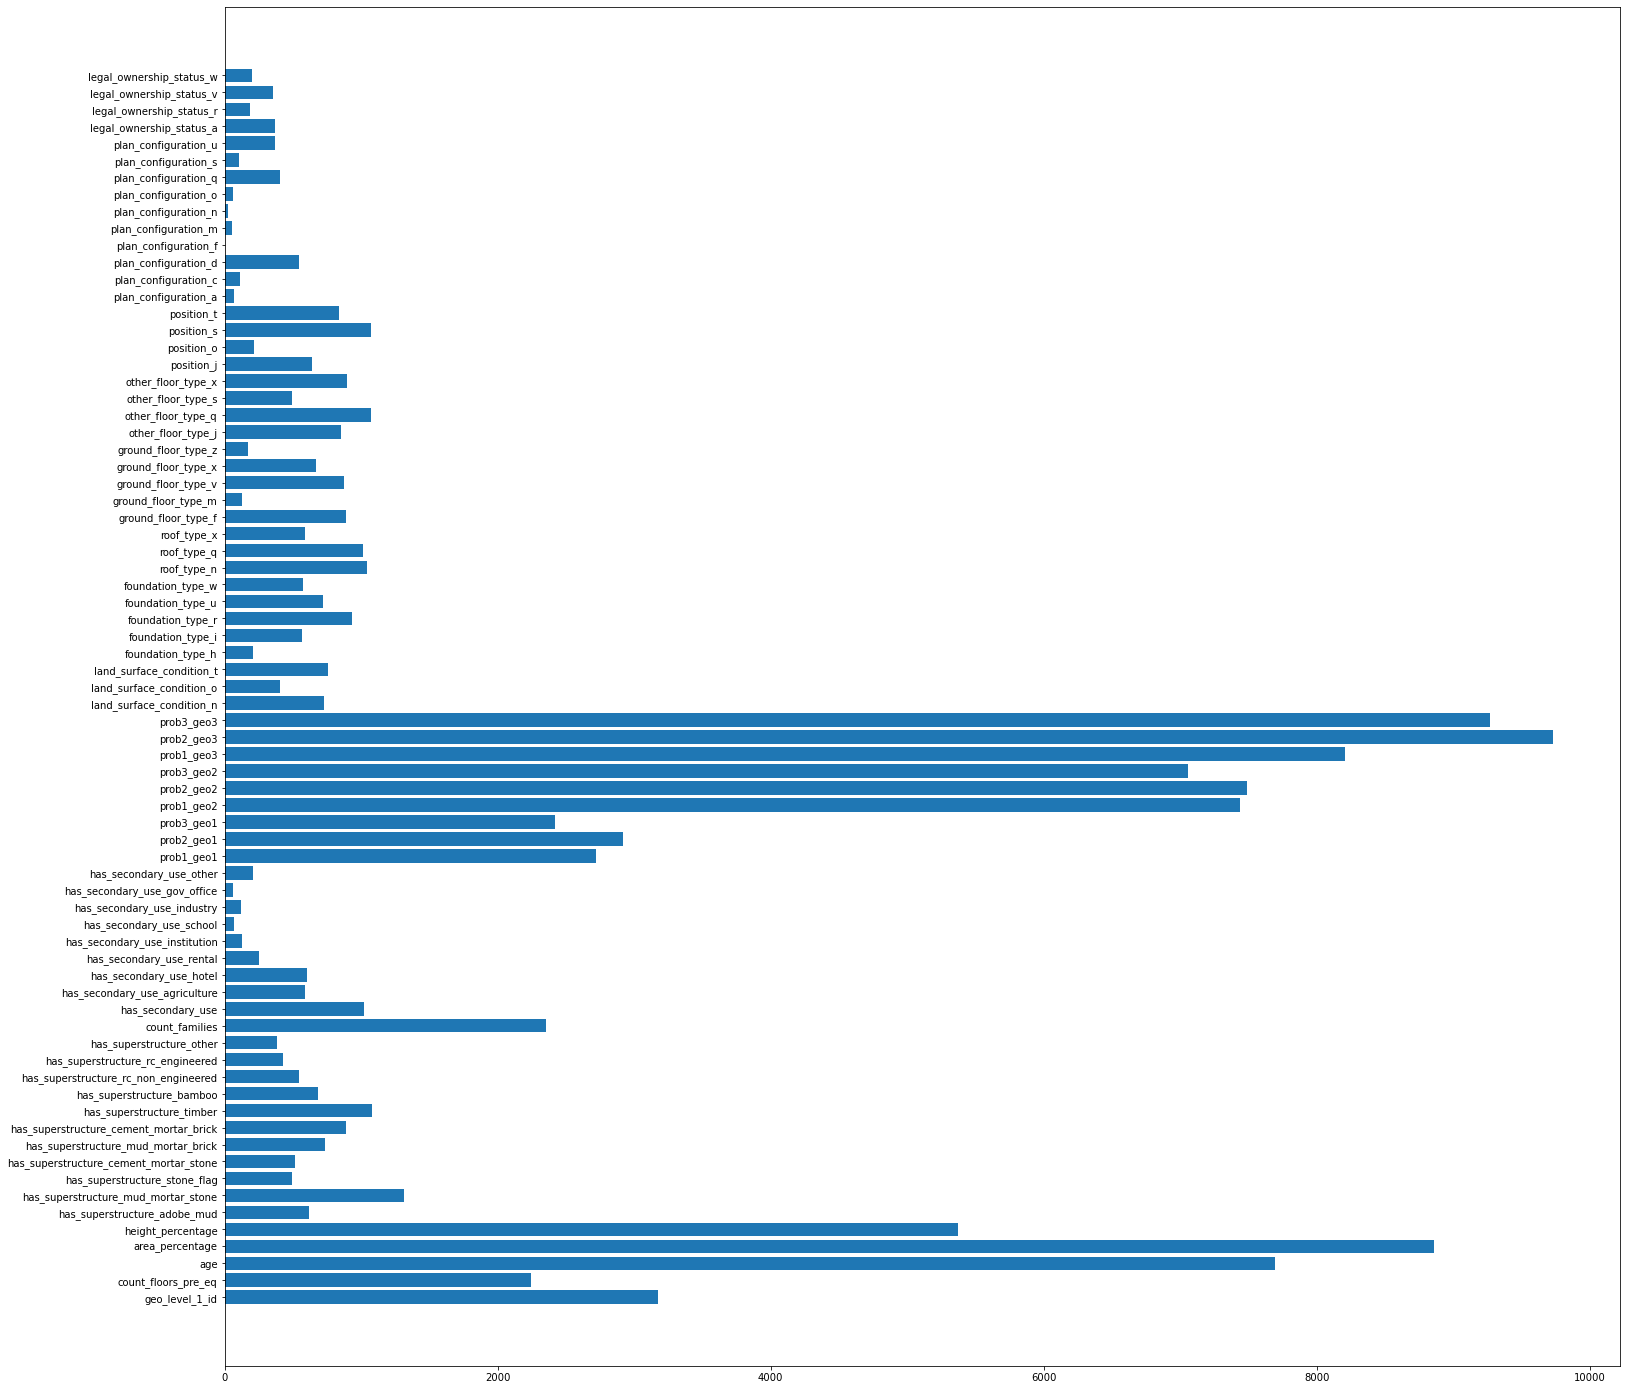

In [193]:
plt.figure(figsize=(25,25))
plt.barh(X.columns, eclf.estimators_[1].feature_importances_)

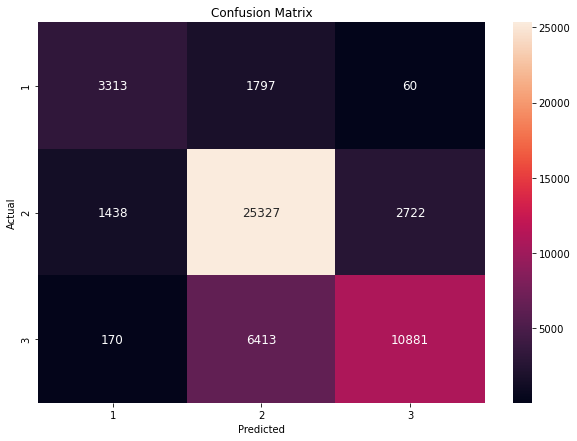

In [194]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in eclf.estimators_
], axis=0)

feature_importances


#plot_confusion_matrix(eclf.estimators_[0],X_test,y_test,values_format='d')

from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = eclf.predict(X_test)

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


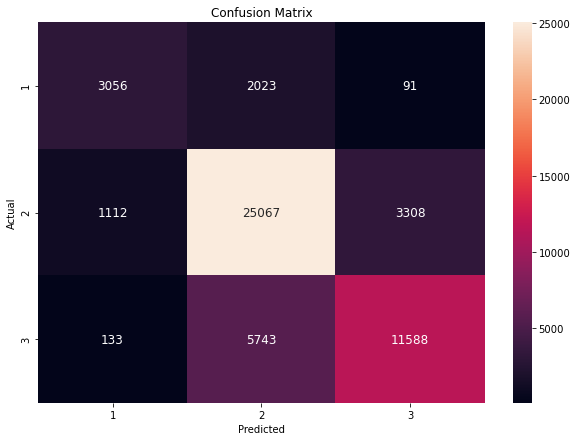

In [195]:
#plot_confusion_matrix(eclf.estimators_[1],X_test,y_test,values_format='d')

y_pred = eclf.estimators_[1].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


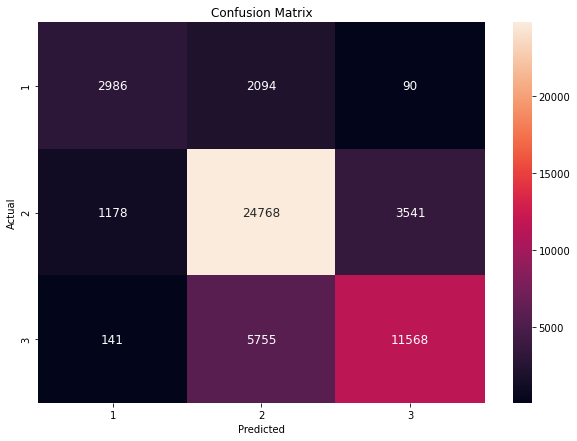

In [196]:
y_pred = eclf.estimators_[0].predict(X_test)

y_pred = [v + 1 for v in y_pred]

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()


In [197]:

#node_params = {'shape' : 'box',
 #             'style': 'filled, rounded',
  #             'fillcolor' : '#78cbe'}

#leaf_params = {'shape' : 'box',
 #             'style': 'filled',
  #             'fillcolor' : '#e48038'}

#xgb.to_graphviz(eclf.estimators_[0],num_trees=0,size="600,600",condition_node_params=node_params,leaf_node_params=leaf_params)

In [198]:
#param_grid = {
     #"n_estimators":[150,200,250],
     # "max_depth": [5,6,7,8,9,10],
#      "learning_rate": [0.1, 0.09, 0.11],
#       "gamma": [0.20, 0.25, 0.30],
#     # "reg_lambda": [0, 1, 10],
#     # "scale_pos_weight": [1, 3, 5],
     
      #  "subsample": [0.95,1,1.05],
#     "colsample_bytree": [0.5,1],
#     "colsample_bynode": [0.5,1],
#     "colsample_bylevel": [0.5,1],
#}

#grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3)


#_ = grid_cv.fit(X_train,y_train)
#xgb_cl.fit(X_train,y_train)

hago el predict de los valores de test

In [199]:
pred_xgboost = eclf.predict(X_test)

In [200]:
f1_score(y_test, pred_xgboost, average ='micro')

0.7582548301068667

In [201]:
#grid_cv.best_params_

In [202]:
#plt.figure(figsize=(20,50))
#plt.barh(X.columns, xgb_cl.feature_importances_)


In [203]:
df_test_encoding.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 0 to 86867
Data columns (total 73 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   geo_level_1_id                          86868 non-null  int64  
 1   count_floors_pre_eq                     86868 non-null  int64  
 2   age                                     86868 non-null  int64  
 3   area_percentage                         86868 non-null  int64  
 4   height_percentage                       86868 non-null  int64  
 5   has_superstructure_adobe_mud            86868 non-null  int64  
 6   has_superstructure_mud_mortar_stone     86868 non-null  int64  
 7   has_superstructure_stone_flag           86868 non-null  int64  
 8   has_superstructure_cement_mortar_stone  86868 non-null  int64  
 9   has_superstructure_mud_mortar_brick     86868 non-null  int64  
 10  has_superstructure_cement_mortar_brick  86868 non-null  in

In [204]:
df_test_encoding.isnull().sum().sum()

0

predigo el df_test y creo el file contra el format csv

In [205]:
pred_xgboost_final = eclf.predict(df_test_encoding)


In [206]:
pred_xgboost_final

array([3, 2, 3, ..., 2, 2, 1], dtype=int64)

In [207]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=pred_xgboost_final,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [208]:
my_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [209]:
fecha = datetime.datetime.now(pytz.timezone("Etc/GMT+3"))
my_submission.to_csv('_training-result.csv',index= True)